#IMPORTING DEPENDENCIES

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import math

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import MeanAbsoluteError
from sklearn.metrics import mean_squared_error

#Load Data

In [3]:
# Load the dataset
data = pd.read_csv('/content/INFOSYS.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,VWAP
0,03-01-2000,122.070313,122.071877,122.070313,122.071877,80.904167,657536.0,122.0713557
1,04-01-2000,131.250000,131.837891,126.976563,131.686722,87.276466,7191808.0,130.1670587
2,05-01-2000,122.664063,126.953125,121.151955,121.151955,80.294495,21069440.0,123.0856783
3,06-01-2000,119.192581,119.531250,111.459763,111.459763,73.870903,10495616.0,114.1502587
4,07-01-2000,102.542969,102.542969,102.542969,102.542969,67.961205,971392.0,102.542969


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5873 entries, 0 to 5872
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5873 non-null   object 
 1   Open       5866 non-null   float64
 2   High       5866 non-null   float64
 3   Low        5866 non-null   float64
 4   Close      5866 non-null   float64
 5   Adj Close  5866 non-null   float64
 6   Volume     5866 non-null   float64
 7   VWAP       5873 non-null   object 
dtypes: float64(6), object(2)
memory usage: 367.2+ KB


#Filtering Data

In [5]:
# Drop rows with null values
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5866 entries, 0 to 5872
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5866 non-null   object 
 1   Open       5866 non-null   float64
 2   High       5866 non-null   float64
 3   Low        5866 non-null   float64
 4   Close      5866 non-null   float64
 5   Adj Close  5866 non-null   float64
 6   Volume     5866 non-null   float64
 7   VWAP       5866 non-null   object 
dtypes: float64(6), object(2)
memory usage: 412.5+ KB


#Feature selection and normalization

In [7]:

features = data[['Open', 'High', 'Low', 'Close', 'Volume']]
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# print(data)


#Split the data into train and test sets

In [8]:
# Convert the data into sequences
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size, 3])
    return np.array(X), np.array(y)

window_size = 100
X, y = create_sequences(scaled_features, window_size)

# Split the data into train and test sets
split_index = int(len(X) * 0.65)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((3747, 100, 5), (2019, 100, 5), (3747,), (2019,))

#LSTM Model Installation

In [9]:
# Build the LSTM model
def build_LSTM_model(window_size, input_shape=(window_size, 5)):
    model = Sequential([
        LSTM(50, activation='tanh', return_sequences=True, input_shape=input_shape),
        Dropout(0.1),
        LSTM(50, activation='tanh'),
        Dense(1)

    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')
    return model


In [11]:
# Initialize and train the model
model = build_LSTM_model(window_size)
history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=64,
                    verbose=1,
                    validation_data=(X_test, y_test),
                    # callbacks=[
                    #     EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
                    #     ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)]
                    )


Epoch 1/100
59/59 [==============================] - 5s 25ms/step - loss: 0.0036 - val_loss: 0.0165
Epoch 2/100
59/59 [==============================] - 1s 12ms/step - loss: 1.3688e-04 - val_loss: 0.0030
Epoch 3/100
59/59 [==============================] - 1s 12ms/step - loss: 8.1644e-05 - val_loss: 0.0017
Epoch 4/100
59/59 [==============================] - 1s 12ms/step - loss: 7.3281e-05 - val_loss: 8.8938e-04
Epoch 5/100
59/59 [==============================] - 1s 12ms/step - loss: 6.6906e-05 - val_loss: 6.1110e-04
Epoch 6/100
59/59 [==============================] - 1s 12ms/step - loss: 6.3540e-05 - val_loss: 6.0790e-04
Epoch 7/100
59/59 [==============================] - 1s 20ms/step - loss: 6.2642e-05 - val_loss: 6.0032e-04
Epoch 8/100
59/59 [==============================] - 2s 28ms/step - loss: 5.7445e-05 - val_loss: 6.4691e-04
Epoch 9/100
59/59 [==============================] - 1s 16ms/step - loss: 5.7282e-05 - val_loss: 6.2142e-04
Epoch 10/100
59/59 [========================

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100, 50)           11200     
                                                                 
 dropout_1 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 31451 (122.86 KB)
Trainable params: 31451 (122.86 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Inverse transform the scaled data
scaled_y_test = scaler.inverse_transform(np.hstack((np.zeros((len(y_test), 4)), y_test.reshape(-1, 1))))
scaled_y_pred = scaler.inverse_transform(np.hstack((np.zeros((len(y_pred), 4)), y_pred.reshape(-1, 1))))

64/64 [==============================] - 1s 6ms/step


#Visualising Graphs

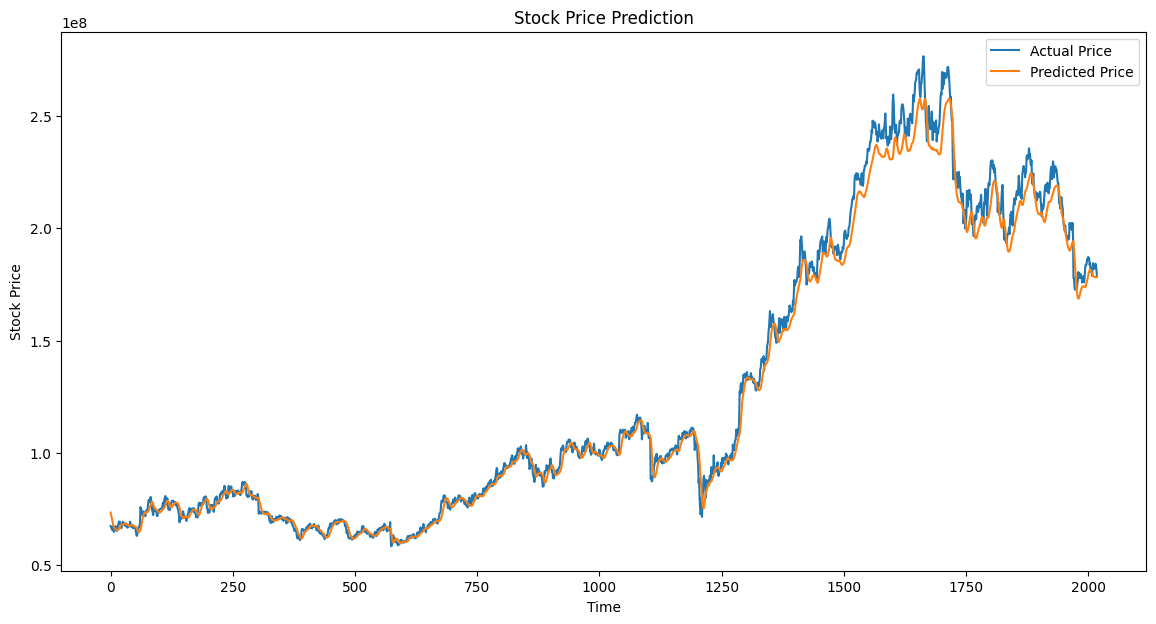

In [14]:
# Plot the predictions vs actual values
plt.figure(figsize=(14, 7))
plt.plot(scaled_y_test[:, -1], label='Actual Price')
plt.plot(scaled_y_pred[:, -1], label='Predicted Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Prepare the data for Plotly
historical_plot_data = pd.DataFrame({
    'Date': data['Date'].iloc[window_size + split_index:].reset_index(drop=True),
    'Actual Price': scaled_y_test[:, -1],
    'Predicted Price': scaled_y_pred[:, -1]
})

# Plotly Line Plot
fig = px.line(historical_plot_data, x='Date', y=['Actual Price', 'Predicted Price'], title='Historical Stock Price Prediction')
fig.show()

#Model Accuracy

In [24]:
from sklearn.metrics import mean_absolute_error

# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate the Root Mean Squared Error (RMSE)
rmse = math.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")


Mean Squared Error (MSE): 0.00048408998022517305
Root Mean Squared Error (RMSE): 0.022002044910079906
Mean Absolute Error (MAE): 0.01469435185722489
